# Data Preprocessing: Assignment 1

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import  PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


At first we need to look at the correlation between the different

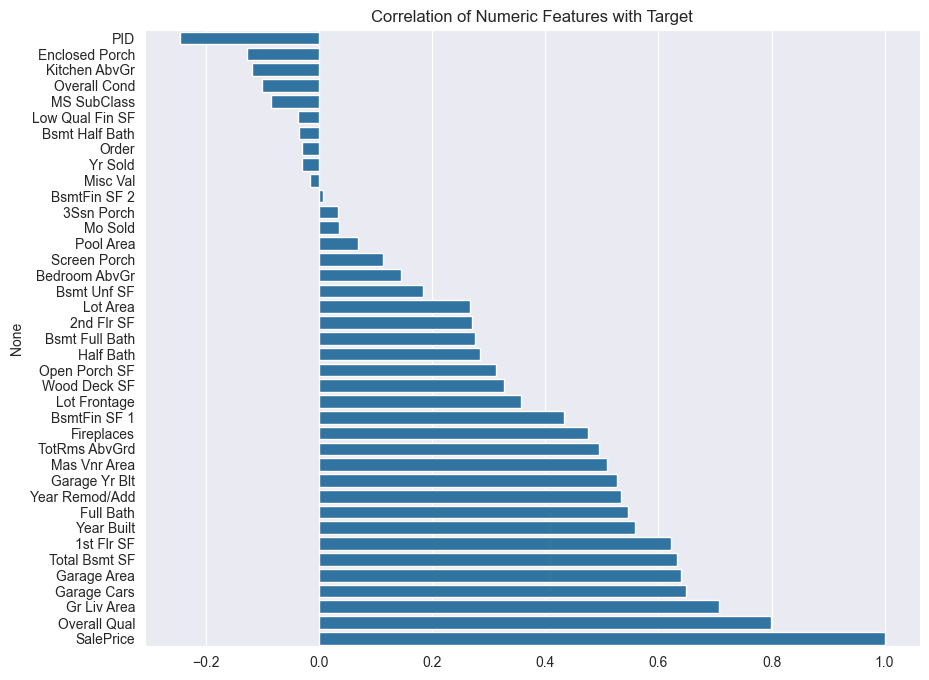

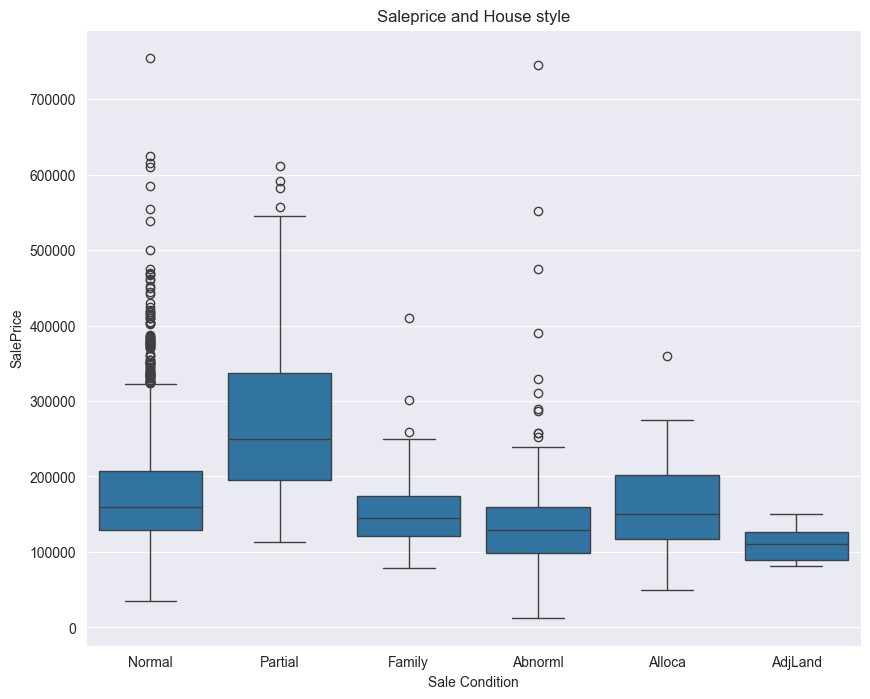

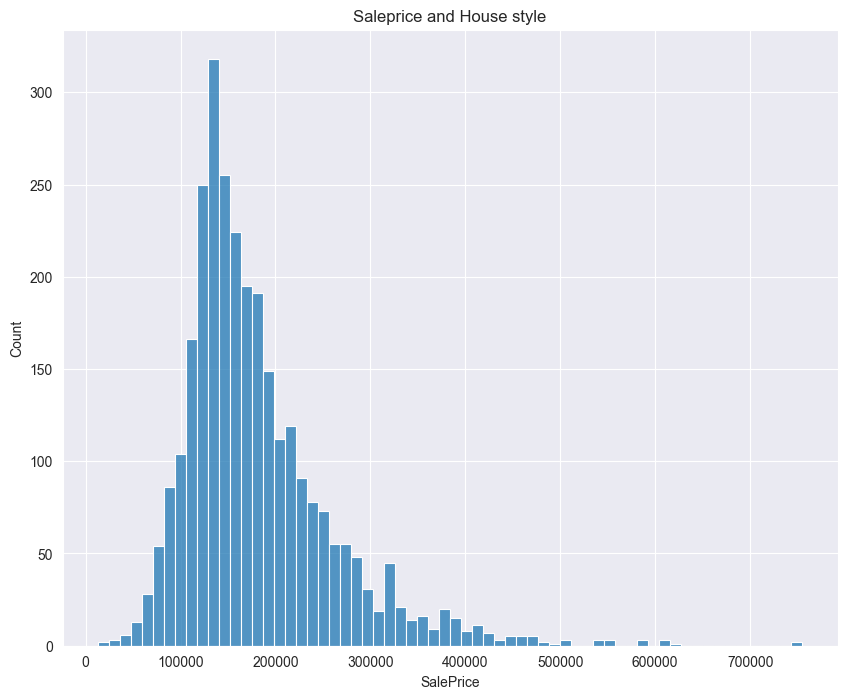

Price split
1    1108
2     732
3     602
4     488
Name: count, dtype: int64


In [10]:
datapath = "Data/AmesHousing.csv"

df_raw = pd.read_csv(datapath)

corr = df_raw.corr(numeric_only=True)['SalePrice'].sort_values()
plt.figure(figsize=(10,8))
sns.barplot(x=corr.values, y=corr.index)
plt.title("Correlation of Numeric Features with Target")
plt.show()

plt.figure(figsize=(10,8))
sns.boxplot(data=df_raw, x='Sale Condition', y='SalePrice')
plt.title("Saleprice and House style")
plt.show()

plt.figure(figsize=(10,8))
sns.histplot(data=df_raw, x='SalePrice')
plt.title("Saleprice and House style")
plt.show()

df_raw['Price split'] = pd.qcut(
    df_raw['Overall Qual'],
    q=4,                 # 5 roughly equal-sized groups
    labels=[1, 2, 3, 4]
)


print(df_raw['Price split'].value_counts().sort_index())

Linear regression

In [11]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in split.split(df_raw, df_raw["Price split"]):
 strat_train_set = df_raw.iloc[train_idx].copy()
 strat_test_set = df_raw.iloc[test_idx].copy()



def proportions(s): return s.value_counts(normalize=True).sort_index()

prop_table = pd.DataFrame({
 'overall': proportions(df_raw['Price split']),
 'train': proportions(strat_train_set['Price split']),
 'test': proportions(strat_test_set['Price split'])})

print(prop_table)

for s in (strat_train_set, strat_test_set):
 s.drop(columns=["Price split"], inplace=True)

X_train = strat_train_set.drop(columns=['SalePrice'])
y_train = strat_train_set['SalePrice'].copy()
X_test = strat_test_set.drop(columns=['SalePrice'])
y_test = strat_test_set['SalePrice'].copy()


              overall     train      test
Price split                              
1            0.378157  0.377986  0.378840
2            0.249829  0.250000  0.249147
3            0.205461  0.205631  0.204778
4            0.166553  0.166382  0.167235


Linear regression, with some help from ChatGPT

In [12]:

# --------------------------
# 1️⃣ Select numeric + strong categorical features
# --------------------------
# Example strong categorical features (you can adjust)
strong_cat_cols = ['Neighborhood', 'HouseStyle', 'ExterQual', 'KitchenQual', 'BsmtQual']
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != 'SalePrice']  # drop target if present

# Filter categorical columns to those in the dataset
cat_cols = [c for c in strong_cat_cols if c in X_train.columns]

# --------------------------
# 2️⃣ Create transformers
# --------------------------
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, cat_cols)
])

# --------------------------
# 3️⃣ Build pipeline with log-transform
# --------------------------
linreg = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', LinearRegression())
])

# Log-transform target
y_train_log = np.log1p(y_train)
y_test_log  = np.log1p(y_test)

# --------------------------
# 4️⃣ Fit and predict
# --------------------------
linreg.fit(X_train, y_train_log)
y_pred_log = linreg.predict(X_test)
y_pred = np.expm1(y_pred_log)  # convert back to original scale

# --------------------------
# 5️⃣ Evaluate
# --------------------------
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_test, y_pred)

print(f"Linear Regression RMSE: {rmse:,.2f}")
print(f"Linear Regression R^2: {r2:.3f}")# Log-transform target


Linear Regression RMSE: 20,294.22
Linear Regression R^2: 0.929


Polynomial features, with ChatGPT help

In [13]:

#Polynomial features

poly_pipeline = Pipeline([
    ('preprocess', preprocess),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('model', LinearRegression())
])

# Fit
poly_pipeline.fit(X_train, y_train_log)


# Predict
y_pred_poly = poly_pipeline.predict(X_test)

# Evaluate
rmse_poly = np.sqrt(mean_squared_error(y_test_log, y_pred_poly))
r2_poly = r2_score(y_test_log, y_pred_poly)

print()
print(f"Polynomial Linear Regression RMSE: {rmse_poly:,.2f}")
print(f"Polynomial Linear Regression R^2: {r2_poly:.3f}")


Polynomial Linear Regression RMSE: 2.92
Polynomial Linear Regression R^2: -56.692


Random forest regressor, with ChatGPT help

In [14]:

rf_pipeline = Pipeline([
    ('preprocess', preprocess),
    ('model', RandomForestRegressor(
        n_estimators=100,
        max_depth=50,
        random_state=42
    ))
])

# Fit
rf_pipeline.fit(X_train, y_train)

# Predict
y_pred_rf = rf_pipeline.predict(X_test)

# Evaluate
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print()
print(f"Random Forest RMSE: {rmse_rf:,.2f}")
print(f"Random Forest R^2: {r2_rf:.3f}")




Random Forest RMSE: 21,881.61
Random Forest R^2: 0.918
